In [1]:
from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import malthus, verhulst, gompertz, runge_kutta

# Modelo de Malthus

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(malthus, T0, X0, TF, H, K)

In [3]:
NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
def Div(left, right):
    if type(right) == float:
        if right == 0:
            #print('div error')
            return 1
        else:
            return left / right
    else:
        # Replace zero terms in the divider array with 1
        right_without_zeros = np.where(right == 0, 1, right)

        # Perform element-wise division
        result = left / right_without_zeros
        return result

def Exp(x):
    try:
        result = np.exp(x)
    except OverflowError:
        print('exp error')
        result = np.ones_like(x)
    return result

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

#pset.addPrimitive(X0_add, 1)
#pset.addPrimitive(X0_mul, 1)
#pset.addPrimitive(X0_div, 1)
#pset.addPrimitive(K_add, 1)
#pset.addPrimitive(K_mul, 1)
#pset.addPrimitive(K_div, 1)

pset.addEphemeralConstant("rand101", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                fitness                	                  size                 
   	      	---------------------------------------	---------------------------------------
gen	nevals	avg    	gen	min    	nevals	std    	avg  	gen	min	nevals	std    
0  	1000  	68.5389	0  	5.06825	1000  	348.771	3.843	0  	2  	1000  	1.62676
1  	501   	inf    	1  	5.06825	501   	nan    	3.739	1  	2  	501   	1.65375
2  	493   	5.37623e+40	2  	5.06825	493   	1.20096e+42	3.576	2  	1  	493   	1.6218 
3  	490   	1.07525e+41	3  	5.06825	490   	1.69671e+42	3.823	3  	1  	490   	1.73714
4  	495   	inf        	4  	5.06825	495   	nan        	4.456	4  	1  	495   	1.93082
5  	554   	inf        	5  	3.06428	554   	nan        	5.012	5  	1  	554   	2.07554


c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


6  	495   	inf        	6  	3.16964e-09	495   	nan        	5.23 	6  	1  	495   	2.11213
7  	472   	inf        	7  	3.16964e-09	472   	nan        	4.98 	7  	1  	472   	2.05173
8  	539   	inf        	8  	3.02806    	539   	nan        	4.779	8  	1  	539   	2.06982
9  	484   	3.0745e+115	9  	1.55263    	484   	9.71756e+116	4.569	9  	1  	484   	1.78528
10 	512   	inf        	10 	1.55263    	512   	nan         	4.573	10 	1  	512   	1.9289 
11 	537   	inf        	11 	1.55263    	537   	nan         	4.781	11 	1  	537   	2.24612
12 	505   	inf        	12 	1.55263    	505   	nan         	5.24 	12 	1  	505   	2.73722
13 	491   	inf        	13 	1.55263    	491   	nan         	6.073	13 	2  	491   	3.2329 
14 	543   	inf        	14 	1.55263    	543   	nan         	7.046	14 	2  	543   	3.61135
15 	496   	inf        	15 	3.16964e-09	496   	nan         	7.827	15 	1  	496   	3.6602 
16 	502   	inf        	16 	3.16964e-09	502   	nan         	8.492	16 	1  	502   	3.48854
17 	510   	inf        	17 	3.16964e

C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_12472/2186209511.py:18: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_12472/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


36 	503   	inf        	36 	3.16964e-09	503   	nan         	7.976	36 	3  	503   	1.46677
37 	542   	inf        	37 	3.16964e-09	542   	nan         	7.938	37 	2  	542   	1.43393
38 	524   	inf        	38 	3.16964e-09	524   	nan         	7.992	38 	1  	524   	1.35275
39 	472   	inf        	39 	3.16964e-09	472   	nan         	7.98 	39 	1  	472   	1.45176
40 	520   	inf        	40 	3.16964e-09	520   	nan         	7.964	40 	3  	520   	1.4801 
41 	483   	inf        	41 	3.16964e-09	483   	nan         	7.938	41 	1  	483   	1.43811
42 	505   	inf        	42 	3.16964e-09	505   	nan         	7.951	42 	1  	505   	1.5539 
43 	483   	inf        	43 	3.16964e-09	483   	nan         	7.968	43 	1  	483   	1.33603
44 	514   	inf        	44 	3.16964e-09	514   	nan         	7.948	44 	1  	514   	1.35768
45 	521   	inf        	45 	3.16964e-09	521   	nan         	7.956	45 	1  	521   	1.44709
46 	519   	inf        	46 	3.16964e-09	519   	nan         	7.999	46 	3  	519   	1.53003
47 	493   	inf        	47 	3.169

In [11]:
for i in hof.items:
    print(str(i))
    print()

add(Exp(t), add(Exp(sub(t, 0)), Exp(t)))

add(Exp(t), add(Exp(t), Exp(mul(t, 1))))

add(Exp(t), add(Exp(t), Exp(Div(t, 1))))

add(add(Exp(t), Exp(t)), Exp(t))

add(Exp(t), add(Exp(t), Exp(t)))



add(Exp(t), add(Exp(sub(t, 0)), Exp(t)))


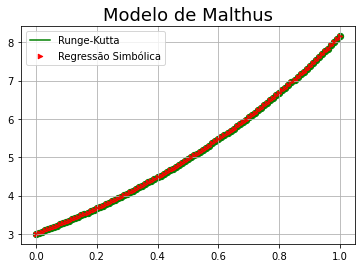

In [12]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Malthus', size = 18)
ax.scatter(T, X, c = 'g', s = 40)
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r', s = 20)
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
plt.savefig('resultados\Resultado_Malthus_1.png', dpi = 200)

In [13]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand102", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
display(sp.expand(func(t)))

3*exp(t)

# Modelo de Verhulst

In [16]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(verhulst, T0, X0, TF, H, K)

In [17]:
NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [18]:
def Div(left, right):
    if type(right) == float:
        if right == 0:
            #print('div error')
            return 1
        else:
            return left / right
    else:
        # Replace zero terms in the divider array with 1
        right_without_zeros = np.where(right == 0, 1, right)

        # Perform element-wise division
        result = left / right_without_zeros
        return result

def Exp(x):
    try:
        result = np.exp(x)
    except OverflowError:
        print('exp error')
        result = np.ones_like(x)
    return result

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

#pset.addPrimitive(X0_add, 1)
#pset.addPrimitive(X0_mul, 1)
#pset.addPrimitive(X0_div, 1)
#pset.addPrimitive(K_add, 1)
#pset.addPrimitive(K_mul, 1)
#pset.addPrimitive(K_div, 1)

pset.addEphemeralConstant("rand103", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [19]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

c:\venv\ilumpy\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\venv\ilumpy\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [20]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [21]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [22]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [23]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [24]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                      fitness                      	                  size                 
   	      	---------------------------------------------------	---------------------------------------
gen	nevals	avg        	gen	min   	nevals	std        	avg  	gen	min	nevals	std    
0  	1000  	2.68812e+40	0  	4.8033	1000  	8.49632e+41	3.871	0  	2  	1000  	1.65419
1  	545   	5.37623e+40	1  	3.76409	545   	1.20096e+42	3.627	1  	1  	545   	1.6923 
2  	526   	2.68812e+40	2  	1.52645	526   	8.49632e+41	3.509	2  	1  	526   	1.67509
3  	525   	2.68812e+40	3  	1.36598	525   	8.49632e+41	3.678	3  	1  	525   	1.76474
4  	549   	10.7511    	4  	1.36598	549   	12.3742    	4.106	4  	1  	549   	1.86514
5  	485   	inf        	5  	1.36598	485   	nan        	4.392	5  	1  	485   	1.86664
6  	519   	25.0229    	6  	1.36598	519   	513.231    	4.546	6  	1  	519   	1.80163


c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_12472/2881555872.py:18: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_12472/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


7  	520   	24.9219    	7  	1.36598	520   	513.28     	4.665	7  	1  	520   	1.82175
8  	495   	inf        	8  	1.36598	495   	nan        	4.86 	8  	1  	495   	1.94227
9  	506   	inf        	9  	1.36598	506   	nan        	5.11 	9  	1  	506   	2.0263 
10 	496   	11.5962    	10 	1.36598	496   	104.623    	5.481	10 	1  	496   	2.08222
11 	541   	inf        	11 	1.36598	541   	nan        	5.735	11 	1  	541   	2.22548
12 	514   	inf        	12 	1.36598	514   	nan        	5.765	12 	1  	514   	2.29211
13 	537   	inf        	13 	1.36598	537   	nan        	5.5  	13 	1  	537   	2.3156 
14 	553   	inf        	14 	1.36598	553   	nan        	5.333	14 	1  	553   	2.22084
15 	479   	inf        	15 	1.36598	479   	nan        	5.019	15 	1  	479   	1.80738
16 	492   	inf        	16 	1.36598	492   	nan        	4.987	16 	1  	492   	1.61023
17 	505   	inf        	17 	1.36598	505   	nan        	4.951	17 	1  	505   	1.62068
18 	463   	inf        	18 	1.36598	463   	nan        	5.006	18 	1  	463   	1.62849
19 	

In [25]:
for i in hof.items:
    print(str(i))
    print()

Exp(Exp(sub(1, Exp(sub(1, Exp(sub(1, Exp(t))))))))

Exp(Exp(sub(Exp(sub(1, Exp(t))), sub(Exp(t), t))))

Exp(Exp(sub(t, sub(Exp(t), Exp(sub(1, Exp(t)))))))

Exp(Exp(sub(sub(1, sub(Exp(t), t)), t)))

Exp(sub(t, sub(t, Exp(sub(1, Exp(t))))))



Exp(Exp(sub(1, Exp(sub(1, Exp(sub(1, Exp(t))))))))


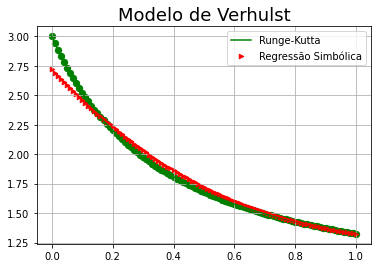

In [26]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Verhulst', size = 18)
ax.scatter(T, X, c = 'g', s = 40)
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r', s = 20)
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
plt.savefig('resultados\Resultado_Verhulst_1.png', dpi = 200)

In [27]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand104", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [28]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [29]:
display(sp.expand(func(t)))

exp(E*exp(-E*exp(-E*exp(-exp(t)))))

# Modelo de Gompertz

In [30]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(gompertz, T0, X0, TF, H, K)

In [31]:
NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [32]:
def Div(left, right):
    if type(right) == float:
        if right == 0:
            #print('div error')
            return 1
        else:
            return left / right
    else:
        # Replace zero terms in the divider array with 1
        right_without_zeros = np.where(right == 0, 1, right)

        # Perform element-wise division
        result = left / right_without_zeros
        return result

def Exp(x):
    try:
        result = np.exp(x)
    except OverflowError:
        print('exp error')
        result = np.ones_like(x)
    return result

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

#pset.addPrimitive(X0_add, 1)
#pset.addPrimitive(X0_mul, 1)
#pset.addPrimitive(X0_div, 1)
#pset.addPrimitive(K_add, 1)
#pset.addPrimitive(K_mul, 1)
#pset.addPrimitive(K_div, 1)

pset.addEphemeralConstant("rand105", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [33]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

c:\venv\ilumpy\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\venv\ilumpy\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [34]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [35]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [36]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [37]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [38]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	               fitness               	                  size                 
   	      	-------------------------------------	---------------------------------------
gen	nevals	avg    	gen	min    	nevals	std  	avg  	gen	min	nevals	std    
0  	1000  	34.7228	0  	2.31984	1000  	329.3	3.958	0  	2  	1000  	1.69477
1  	563   	2.68812e+40	1  	2.31984	563   	8.49632e+41	3.652	1  	1  	563   	1.57127
2  	520   	2.68812e+40	2  	2.31984	520   	8.49632e+41	3.537	2  	1  	520   	1.5845 
3  	510   	10.8177    	3  	2.31984	510   	15.742     	3.375	3  	1  	510   	1.60137
4  	554   	11.146     	4  	2.31984	554   	19.1015    	3.58 	4  	1  	554   	1.56895
5  	483   	38343.9    	5  	2.31984	483   	1.21159e+06	3.817	5  	1  	483   	1.53672
6  	492   	8.60372    	6  	2.31984	492   	18.1666    	3.991	6  	1  	492   	1.45083
7  	508   	9.10725    	7  	2.31984	508   	20.6254    	3.987	7  	1  	508   	1.34567
8  	534   	2.66137e+40	8  	2.31984	534   	8.41178e+41	4.179	8  	1  	534   	1.40034
9  	544   	1

c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


21 	531   	inf        	21 	2.20347	531   	nan        	6.33 	21 	1  	531   	2.08689
22 	535   	inf        	22 	2.20347	535   	nan        	6.541	22 	1  	535   	2.22538
23 	494   	inf        	23 	2.20347	494   	nan        	6.894	23 	1  	494   	2.39891
24 	513   	inf        	24 	2.20347	513   	nan        	7.302	24 	1  	513   	2.63719


C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_12472/820807676.py:18: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_12472/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


25 	505   	inf        	25 	2.20347	505   	nan        	7.55 	25 	1  	505   	2.75926
26 	557   	inf        	26 	2.20347	557   	nan        	7.657	26 	1  	557   	2.86031
27 	490   	inf        	27 	2.20347	490   	nan        	7.728	27 	1  	490   	2.8457 
28 	497   	inf        	28 	2.20347	497   	nan        	7.648	28 	1  	497   	2.78138
29 	518   	inf        	29 	1.4593 	518   	nan        	7.7  	29 	2  	518   	2.74518
30 	462   	inf        	30 	1.4593 	462   	nan        	7.7  	30 	1  	462   	2.72287
31 	486   	inf        	31 	1.4593 	486   	nan        	7.725	31 	1  	486   	2.75452
32 	484   	inf        	32 	1.4593 	484   	nan        	7.596	32 	1  	484   	2.61472
33 	493   	inf        	33 	1.4593 	493   	nan        	7.58 	33 	1  	493   	2.7462 
34 	510   	inf        	34 	1.4593 	510   	nan        	7.543	34 	1  	510   	2.94043
35 	529   	inf        	35 	1.4593 	529   	nan        	7.149	35 	1  	529   	2.64212
36 	491   	inf        	36 	1.4593 	491   	nan        	7.29 	36 	1  	491   	2.7644 
37 	

In [39]:
for i in hof.items:
    print(str(i))
    print()

Exp(sub(1, mul(1, mul(sub(1, Exp(-1)), t))))

Exp(sub(1, mul(sub(Div(1, 1), Exp(-1)), t)))

Exp(sub(1, mul(sub(1, Exp(Div(1, -1))), t)))

Exp(sub(1, mul(t, sub(1, Exp(-1)))))

Exp(sub(1, mul(sub(1, Exp(-1)), t)))



Exp(sub(1, mul(1, mul(sub(1, Exp(-1)), t))))


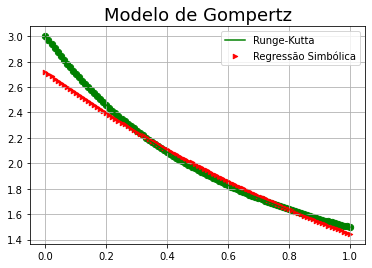

In [40]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Gompertz', size = 18)
ax.scatter(T, X, c = 'g', s = 40)
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r', s = 20)
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
plt.savefig('resultados\Resultado_Gompertz_1.png', dpi = 200)

In [41]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand106", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [42]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [43]:
display(sp.expand(func(t)))

E*exp(-t)*exp(t*exp(-1))